In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from geopy import distance
import itertools
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# Загрузка данных о перелетах и обработка переменных

In [2]:
# данные о перелетах в России взяты с этого сайта: https://www.airfleets.net/home/
df = pd.read_csv('../data_preprocessed/data.csv')
df = df[['Date', 'Flight', 'Departure', 'Arrival', 'Aircraft']]
df.shape

(4526, 5)

In [3]:
# переименование столбцов
dict_with_names = {'Date':'date', 'Flight':'flight', 'Departure':'dep', 'Arrival':'arr', 'Aircraft':'aircraft'}
df.rename(columns = dict_with_names, inplace = True)

# Создание новых столбцов
df['year'] = df['date'].apply(lambda x: x[6:10])
df['date'] = pd.to_datetime(df['date'].apply(lambda x: x[:10]))
df['company'] = df['flight'].apply(lambda x: x.split()[0])

df['dep_code'] = df['dep'].apply(lambda x: x[:3])
df['dep_airport'] = df['dep'].apply(lambda x: x[3:-10]) # убрать пробелы
df['dep_airport'] = df['dep_airport'].apply(lambda s: s[:-1] if s[-1] == ' ' else s)

df['arr_code'] = df['arr'].apply(lambda x: x[:3])
df['arr_airport'] = df['arr'].apply(lambda x: x[3:-10])
df['arr_airport'] = df['arr_airport'].apply(lambda s: s[:-1] if s[-1] == ' ' else s)
df.drop(columns = ['flight','dep','arr','aircraft'],inplace = True) # избавились от информации о самолёте

<AxesSubplot:>

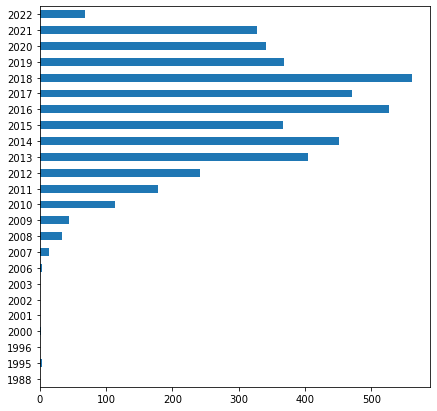

In [4]:
df.year.value_counts().sort_index().plot(kind='barh', figsize = (7,7))

In [5]:
arr_num, dep_num = df['arr_airport'].nunique(), df['dep_airport'].nunique()
print(f'Количество аэропортов, в которые прилетали: {arr_num}')
print(f'Количество аэропортов, из которых вылетали: {dep_num}') # это множество - подмножество множества выше

Количество аэропортов, в которые прилетали: 37
Количество аэропортов, из которых вылетали: 29


In [6]:
set_1 = set(df['arr_airport'].unique())
set_2 = set(df['dep_airport'].unique())
set_3 = set_1.union(set_2)
print(len(set_3))
print(set_3 == set_1)
print(set_2.issubset(set_1))

37
True
True


# Добавление данных о координатах и типах аэропортов

In [7]:
# Данные получены с этого сайта: https://www.prokerala.com/travel/airports/russia/
# и этого: https://ourairports.com/
arr_conditions = [
    (df['arr_airport'] == 'Adler'),
    (df['arr_airport'] == 'Anapa'),
    (df['arr_airport'] == 'Belgorod'), # X
    (df['arr_airport'] == 'Bryansk'), # X
    (df['arr_airport'] == 'Chelyabinsk'),
    (df['arr_airport'] == 'Cherepovets'), # X
    (df['arr_airport'] == 'Ekaterinburg'),
    (df['arr_airport'] == 'Irkutsk'),
    (df['arr_airport'] == 'Kaliningrad Khrabrovo Airport'),
    (df['arr_airport'] == 'Kazan'),
    (df['arr_airport'] == 'Kemerovo'), # X
    (df['arr_airport'] == 'Khabarovsk'),
    (df['arr_airport'] == 'Krasnodar Pashkovskiy'),
    (df['arr_airport'] == 'Krasnojarsk'),
    (df['arr_airport'] == 'Magadan'),
    (df['arr_airport'] == 'Mineralnyye Vody'),
    (df['arr_airport'] == 'Moscow Domodedovo'),
    (df['arr_airport'] == 'Moscow Sheremetyevo'),
    (df['arr_airport'] == 'Moscow Vnukovo'),
    (df['arr_airport'] == 'Moscow Zhukovsky'), # X
    (df['arr_airport'] == 'Murmansk'), # X
    (df['arr_airport'] == 'Nizhniy Novgorod'),
    (df['arr_airport'] == 'Novosibirsk'),
    (df['arr_airport'] == 'Omsk'), # X
    (df['arr_airport'] == 'Perm Oblast'),
    (df['arr_airport'] == 'Rostov'),
    (df['arr_airport'] == 'Samara'),
    (df['arr_airport'] == 'St Petersburg Pulkovo'),
    (df['arr_airport'] == 'Surgut'),
    (df['arr_airport'] == 'Tomsk'),
    (df['arr_airport'] == 'Tyumen'),
    (df['arr_airport'] == 'Ufa'),
    (df['arr_airport'] == 'Vladivostok'),
    (df['arr_airport'] == 'Volgograd'), # X
    (df['arr_airport'] == 'Voronezh'),
    (df['arr_airport'] == 'Yakutsk'),
    (df['arr_airport'] == 'Yuzhno-Sakhalinsk')
    ]

lat = [43.445,45.0021,50.6433,53.2142,55.305,59.2736,56.743099,52.2681,
       54.8827,55.6062,55.2717,48.528338,45.034698,56.1717,
       59.9111,44.225,55.4086,55.9739,55.6041,55.553299,68.7817,
       56.23,55.019756,54.9575,57.9167,47.2583,53.504902,
       59.800301,61.343700,56.380299,57.189602,54.5575,
       43.399,48.7817,51.814201,62.0933,46.8837]

long = [39.9483,37.3473,36.59,34.1764,61.505,38.0158,60.802700,104.389,
       20.5866,49.2787,86.11,135.188588,39.170502,92.4933,
       150.721,43.0833,37.9061,37.4141,37.2909,38.150002,32.7508,
       43.7867,82.618675,73.3167,56.0267,39.8183,50.164299,
       30.262501,73.401802,85.208298,65.324303,55.8744,
       132.148,44.3467,39.229599,129.772,142.742]

airport_type = ['Large','Medium','Medium','Medium','Medium','Medium','Large','Medium',
                'Medium','Medium','Medium','Medium','Medium','Large',
                'Medium','Medium','Large','Large','Medium','Large','Medium',
                'Medium','Large','Medium','Medium','Medium','Large',
                'Large','Medium','Medium','Medium','Large',
                'Medium','Medium','Medium','Medium','Medium']

df['arr_lat'] = np.select(arr_conditions, lat)
df['arr_long'] = np.select(arr_conditions, long)
df['arr_coord'] = list(zip(df['arr_lat'],df['arr_long']))
df['arr_airport_type'] = np.select(arr_conditions, airport_type)

In [8]:
# Данные получены с этого сайта: https://www.prokerala.com/travel/airports/russia/
# и этого: https://ourairports.com/
dep_conditions = [
    (df['dep_airport'] == 'Adler'),
    (df['dep_airport'] == 'Anapa'),
    (df['dep_airport'] == 'Chelyabinsk'),
    (df['dep_airport'] == 'Ekaterinburg'),
    (df['dep_airport'] == 'Irkutsk'),
    (df['dep_airport'] == 'Kaliningrad Khrabrovo Airport'),
    (df['dep_airport'] == 'Kazan'),
    (df['dep_airport'] == 'Khabarovsk'),
    (df['dep_airport'] == 'Krasnodar Pashkovskiy'),
    (df['dep_airport'] == 'Krasnojarsk'),
    (df['dep_airport'] == 'Magadan'),
    (df['dep_airport'] == 'Mineralnyye Vody'),
    (df['dep_airport'] == 'Moscow Domodedovo'),
    (df['dep_airport'] == 'Moscow Sheremetyevo'),
    (df['dep_airport'] == 'Moscow Vnukovo'),
    (df['dep_airport'] == 'Nizhniy Novgorod'),
    (df['dep_airport'] == 'Novosibirsk'),
    (df['dep_airport'] == 'Perm Oblast'),
    (df['dep_airport'] == 'Rostov'),
    (df['dep_airport'] == 'Samara'),
    (df['dep_airport'] == 'St Petersburg Pulkovo'),
    (df['dep_airport'] == 'Surgut'),
    (df['dep_airport'] == 'Tomsk'),
    (df['dep_airport'] == 'Tyumen'),
    (df['dep_airport'] == 'Ufa'),
    (df['dep_airport'] == 'Vladivostok'),
    (df['dep_airport'] == 'Voronezh'),
    (df['dep_airport'] == 'Yakutsk'),
    (df['dep_airport'] == 'Yuzhno-Sakhalinsk')
    ]

lat = [43.445,45.0021,55.305,56.743099,52.2681,
       54.8827,55.6062,48.528338,45.034698,56.1717,
       59.9111,44.225,55.4086,55.9739,55.6041,
       56.23,55.019756,57.9167,47.2583,53.504902,
       59.800301,61.343700,56.380299,57.189602,54.5575,
       43.399,51.814201,62.0933,46.8837]

long = [39.9483,37.3473,61.505,60.802700,104.389,
       20.5866,49.2787,135.188588,39.170502,92.4933,
       150.721,43.0833,37.9061,37.4141,37.2909,
       43.7867,82.618675,56.0267,39.8183,50.164299,
       30.262501,73.401802,85.208298,65.324303,55.8744,
       132.148,39.229599,129.772,142.742]

airport_type = ['Large','Medium','Medium','Large','Medium',
                'Medium','Medium','Medium','Medium','Large',
                'Medium','Medium','Large','Large','Medium',
                'Medium','Large','Medium','Medium','Large',
                'Large','Medium','Medium','Medium','Large',
                'Medium','Medium','Medium','Medium']

df['dep_lat'] = np.select(dep_conditions, lat)
df['dep_long'] = np.select(dep_conditions, long)
df['dep_coord'] = list(zip(df['dep_lat'],df['dep_long']))
df['dep_airport_type'] = np.select(dep_conditions, airport_type)

### Добавление данных о населении городов

In [9]:
# Данные о населении городов на 1 января 2018 года: https://города-россия.рф
arr_conditions = [
    (df['arr_airport'] == 'Adler'),
    (df['arr_airport'] == 'Anapa'),
    (df['arr_airport'] == 'Belgorod'), 
    (df['arr_airport'] == 'Bryansk'), 
    (df['arr_airport'] == 'Chelyabinsk'),
    (df['arr_airport'] == 'Cherepovets'), 
    (df['arr_airport'] == 'Ekaterinburg'),
    (df['arr_airport'] == 'Irkutsk'),
    (df['arr_airport'] == 'Kaliningrad Khrabrovo Airport'),
    (df['arr_airport'] == 'Kazan'),
    (df['arr_airport'] == 'Kemerovo'), 
    (df['arr_airport'] == 'Khabarovsk'),
    (df['arr_airport'] == 'Krasnodar Pashkovskiy'),
    (df['arr_airport'] == 'Krasnojarsk'),
    (df['arr_airport'] == 'Magadan'),
    (df['arr_airport'] == 'Mineralnyye Vody'),
    (df['arr_airport'] == 'Moscow Domodedovo'),
    (df['arr_airport'] == 'Moscow Sheremetyevo'),
    (df['arr_airport'] == 'Moscow Vnukovo'),
    (df['arr_airport'] == 'Moscow Zhukovsky'), 
    (df['arr_airport'] == 'Murmansk'), 
    (df['arr_airport'] == 'Nizhniy Novgorod'),
    (df['arr_airport'] == 'Novosibirsk'),
    (df['arr_airport'] == 'Omsk'), 
    (df['arr_airport'] == 'Perm Oblast'),
    (df['arr_airport'] == 'Rostov'),
    (df['arr_airport'] == 'Samara'),
    (df['arr_airport'] == 'St Petersburg Pulkovo'),
    (df['arr_airport'] == 'Surgut'),
    (df['arr_airport'] == 'Tomsk'),
    (df['arr_airport'] == 'Tyumen'),
    (df['arr_airport'] == 'Ufa'),
    (df['arr_airport'] == 'Vladivostok'),
    (df['arr_airport'] == 'Volgograd'), 
    (df['arr_airport'] == 'Voronezh'),
    (df['arr_airport'] == 'Yakutsk'),
    (df['arr_airport'] == 'Yuzhno-Sakhalinsk')
    ]

arr_population = [424,76,392,406,1202,
                  318,1469,624,475,1244,
                  559,618,900,1091,93,
                  75,12506,12506,12506,12506,
                  295,1259,1613,1172,1052,
                  1130,1163,5352,366,574,
                  768,1121,605,1014,1048,
                  312,199]
df['arr_population'] = np.select(arr_conditions, arr_population)

In [10]:
# Данные о населении городов на 1 января 2018 года: https://города-россия.рф
dep_conditions = [
    (df['dep_airport'] == 'Adler'),
    (df['dep_airport'] == 'Anapa'),
    (df['dep_airport'] == 'Belgorod'), 
    (df['dep_airport'] == 'Bryansk'), 
    (df['dep_airport'] == 'Chelyabinsk'),
    (df['dep_airport'] == 'Cherepovets'), 
    (df['dep_airport'] == 'Ekaterinburg'),
    (df['dep_airport'] == 'Irkutsk'),
    (df['dep_airport'] == 'Kaliningrad Khrabrovo Airport'),
    (df['dep_airport'] == 'Kazan'),
    (df['dep_airport'] == 'Kemerovo'), 
    (df['dep_airport'] == 'Khabarovsk'),
    (df['dep_airport'] == 'Krasnodar Pashkovskiy'),
    (df['dep_airport'] == 'Krasnojarsk'),
    (df['dep_airport'] == 'Magadan'),
    (df['dep_airport'] == 'Mineralnyye Vody'),
    (df['dep_airport'] == 'Moscow Domodedovo'),
    (df['dep_airport'] == 'Moscow Sheremetyevo'),
    (df['dep_airport'] == 'Moscow Vnukovo'),
    (df['dep_airport'] == 'Moscow Zhukovsky'), 
    (df['dep_airport'] == 'Murmansk'), 
    (df['dep_airport'] == 'Nizhniy Novgorod'),
    (df['dep_airport'] == 'Novosibirsk'),
    (df['dep_airport'] == 'Omsk'), 
    (df['dep_airport'] == 'Perm Oblast'),
    (df['dep_airport'] == 'Rostov'),
    (df['dep_airport'] == 'Samara'),
    (df['dep_airport'] == 'St Petersburg Pulkovo'),
    (df['dep_airport'] == 'Surgut'),
    (df['dep_airport'] == 'Tomsk'),
    (df['dep_airport'] == 'Tyumen'),
    (df['dep_airport'] == 'Ufa'),
    (df['dep_airport'] == 'Vladivostok'),
    (df['dep_airport'] == 'Volgograd'), 
    (df['dep_airport'] == 'Voronezh'),
    (df['dep_airport'] == 'Yakutsk'),
    (df['dep_airport'] == 'Yuzhno-Sakhalinsk')
    ]

dep_population = [424,76,392,406,1202,
                  318,1469,624,475,1244,
                  559,618,900,1091,93,
                  75,12506,12506,12506,12506,
                  295,1259,1613,1172,1052,
                  1130,1163,5352,366,574,
                  768,1121,605,1014,1048,
                  312,199]
df['dep_population'] = np.select(dep_conditions, dep_population)

# Добавление информации о том, является ли город миллионером и туристическим

In [11]:
df['arr_megapolis'] = (df['arr_population']>1000)*1
df['dep_megapolis'] = (df['dep_population']>1000)*1

In [12]:
# данные взяты с сайта: http://towntravel.ru/interesnie-fakti-o-gorodah-rossyi/samye-populyarnye-goroda-rossii-top-50-za-2018-2019-god.html
# рейтинг туристических городов создан на основе поисковых запросов в Яндексе за 2018 и 2019 год: «достопримечательности… » и «что посмотреть в… »
df['arr_tourist'] = ((df['arr_airport'] == 'Moscow Domodedovo') |
(df['arr_airport'] == 'Moscow Sheremetyevo') | (df['arr_airport'] == 'Moscow Vnukovo') |
(df['arr_airport'] == 'Moscow Zhukovsky') | (df['arr_airport'] == 'St Petersburg Pulkovo') |
(df['arr_airport'] == 'Kazan') | (df['arr_airport'] == 'Adler'))*1

df['dep_tourist'] = ((df['dep_airport'] == 'Moscow Domodedovo') |
(df['dep_airport'] == 'Moscow Sheremetyevo') | (df['dep_airport'] == 'Moscow Vnukovo') |
(df['dep_airport'] == 'Moscow Zhukovsky') | (df['dep_airport'] == 'St Petersburg Pulkovo') |
(df['dep_airport'] == 'Kazan') | (df['dep_airport'] == 'Adler'))*1

# Добавление пары городов

In [13]:
df['pair'] = df.apply(lambda df: min(df.arr_code,df.dep_code)+'_'+max(df.arr_code,df.dep_code), axis = 1)

# Добавление бинарного таргета

In [14]:
df['entry'] = 1

# Создание датасета с характеристиками аэропортов

In [15]:
airport_data = df[['arr_code','arr_airport','arr_coord','arr_airport_type',
                   'arr_population','arr_megapolis','arr_tourist']]
dict_with_names = {'arr_code':'code','arr_airport':'airport','arr_coord':'coord','arr_airport_type':'type',
                   'arr_population':'population','arr_megapolis':'megapolis','arr_tourist':'tourist'}
airport_data.rename(columns = dict_with_names, inplace = True)
airport_data.drop_duplicates(inplace = True)

C:\Users\fedor\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-15-e75e6dccab94>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airport_data.drop_duplicates(inplace = True)


# Создание развернутых датасетов за определенные годы

In [16]:
def make_df_with_entry(df, airport_data, period_1: str, period_2: str):
    df_first = df[df['year'] == period_1]
    df_second = df[df['year'] == period_2]

    set_1, set_2, set_3, set_4 = set(df_first['arr_code'].unique()),set(df_second['arr_code'].unique()),\
    set(df_first['dep_code'].unique()),set(df_second['dep_code'].unique())
    airports = list(set_1.union(set_2,set_3,set_4))

    list_combo = list(itertools.combinations(airports,2))
    data = pd.DataFrame()
    data['code_0'] = [item[0] for item in list_combo]
    data['code_1'] = [item[1] for item in list_combo]

    data['pair'] = data.apply(lambda data: min(data.code_0,data.code_1)+'_'+max(data.code_0,data.code_1) if data.code_0 != data.code_1 else 'DROP', axis = 1)
    data.drop(data[data.pair == 'DROP'].index, inplace=True)

    # убираем перелеты из Мск в Мск
    msc = list(
        itertools.product(df[df['arr_airport'].apply(lambda s: s[:6]) == 'Moscow']['arr_code'].unique(),
                          df[df['arr_airport'].apply(lambda s: s[:6]) == 'Moscow']['arr_code'].unique()))
    new_list = []
    for item in msc:
        new_list.append(item[0] + '_' + item[1])
    data = data[~data['pair'].isin(new_list)]

    companies = list(set(df_second['company'].unique()))
    data_new = pd.DataFrame({'company':companies}).merge(data['pair'], how = 'cross')
    data_new = data_new.merge(data, how = 'left')

    airport_df = airport_data.copy()
    airport_df.columns = [x + '_0' for x in airport_data.columns]
    data_new = data_new.merge(airport_df)

    airport_df = airport_data.copy()
    airport_df.columns = [x + '_1' for x in airport_data.columns]
    data_new = data_new.merge(airport_df)

    df_first_grouped = df_first.groupby(['company','pair'])['entry'].first().reset_index()
    df_second_grouped = df_second.groupby(['company','pair'])['entry'].first().reset_index()

    data_first = data_new.merge(df_first_grouped, how ='left').fillna(0)
    data_second = data_new.merge(df_second_grouped, how ='left').fillna(0)
    final_data = data_second.copy()
    
    dict_with_num_airports = dict()
    for company, mdf in data_first.groupby('company'):
        dict_with_num_airports[company] = len(list(set(mdf[mdf['entry'] == 1].code_0.unique()).union(
            set(mdf[mdf['entry'] == 1].code_1.unique()))))
    final_data['served_airports_pr_period'] = final_data.company.map(dict_with_num_airports)
    
    list_with_neigh_airports = []
    for index, row in data_first.iterrows():
        tmp = data_first[(data_first['company'] == row['company']) &\
                         ~((data_first['code_0'] == row['code_0']) & (data_first['code_1'] == row['code_1']))]
        num = tmp[(tmp['code_0'] == row['code_0']) | (tmp['code_0'] == row['code_1']) |\
                 (tmp['code_1'] == row['code_0']) | (tmp['code_1'] == row['code_1'])].entry.sum()
        list_with_neigh_airports.append(num)
    final_data['neigh_airports_pr_period'] = list_with_neigh_airports
    
    final_data['entry'] = data_second.entry
    final_data['entry_2'] = (data_second.entry - data_first.entry == 1)*1
    final_data['distance_km'] = final_data.apply(lambda data: distance.distance(data.coord_0, data.coord_1).km, axis = 1)
    final_data['distance_km_squared'] = final_data['distance_km']**2
    
    final_data['type_0'] = (final_data['type_0'] == 'Large')*1
    final_data['type_1'] = (final_data['type_1'] == 'Large')*1
    final_data['airport_type'] = final_data['type_0'] + final_data['type_1']
    final_data['population'] = (final_data['population_0'] * final_data['population_1'])**0.5
    final_data['megapolis'] = final_data['megapolis_0'] + final_data['megapolis_1']
    final_data['tourist'] = final_data['tourist_0'] + final_data['tourist_1']
    
    final_data = final_data[['company','served_airports_pr_period','neigh_airports_pr_period','pair',
                             'airport_type','population','megapolis','tourist',
                             'distance_km','distance_km_squared','entry','entry_2']]
    return final_data

In [17]:
df_2013_2014 = make_df_with_entry(df, airport_data, '2013', '2014')
df_2014_2015 = make_df_with_entry(df, airport_data, '2014', '2015')
df_2015_2016 = make_df_with_entry(df, airport_data, '2015', '2016')
df_2016_2017 = make_df_with_entry(df, airport_data, '2016', '2017')
df_2017_2018 = make_df_with_entry(df, airport_data, '2017', '2018')

In [18]:
df_2017_2018.head()

,company,served_airports_pr_period,neigh_airports_pr_period,pair,airport_type,population,megapolis,tourist,distance_km,distance_km_squared,entry,entry_2
0,AFL,9,0.0,CEK_OVB,1,1392.417323,2,0,1340.909008,1.798037e+06,0.0,0
1,SDM,4,0.0,CEK_OVB,1,1392.417323,2,0,1340.909008,1.798037e+06,0.0,0
2,HZ,2,0.0,CEK_OVB,1,1392.417323,2,0,1340.909008,1.798037e+06,0.0,0
3,AUL,0,0.0,CEK_OVB,1,1392.417323,2,0,1340.909008,1.798037e+06,0.0,0
4,5N,0,0.0,CEK_OVB,1,1392.417323,2,0,1340.909008,1.798037e+06,0.0,0


In [26]:
df_2013_2014.entry_2.value_counts(normalize = True)

0    0.994949
1    0.005051
Name: entry_2, dtype: float64

In [27]:
df_2014_2015.entry_2.value_counts(normalize = True)

0    0.993897
1    0.006103
Name: entry_2, dtype: float64

In [28]:
df_2015_2016.entry_2.value_counts(normalize = True)

0    0.99297
1    0.00703
Name: entry_2, dtype: float64

In [29]:
df_2016_2017.entry_2.value_counts(normalize = True)

0    0.99376
1    0.00624
Name: entry_2, dtype: float64

In [30]:
df_2017_2018.entry_2.value_counts(normalize = True)

0    0.993426
1    0.006574
Name: entry_2, dtype: float64

In [33]:
np.mean([round(df_2013_2014.entry_2.value_counts(normalize = True)[1],3),
 round(df_2014_2015.entry_2.value_counts(normalize = True)[1],3),
 round(df_2015_2016.entry_2.value_counts(normalize = True)[1],3),
 round(df_2016_2017.entry_2.value_counts(normalize = True)[1],3),
 round(df_2017_2018.entry_2.value_counts(normalize = True)[1],3)])

0.0062

In [25]:
df_2013_2014.to_csv('../data_preprocessed/data_2013_2014.csv', index = False)
df_2014_2015.to_csv('../data_preprocessed/data_2014_2015.csv', index = False)
df_2015_2016.to_csv('../data_preprocessed/data_2015_2016.csv', index = False)
df_2016_2017.to_csv('../data_preprocessed/data_2016_2017.csv', index = False)
df_2017_2018.to_csv('../data_preprocessed/data_2017_2018.csv', index = False)